# Experimental results for active learning sampling strategies

In [1]:
%load_ext blackcellmagic

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle

2023-09-23 22:46:48.287597: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
%matplotlib inline

In [4]:
import os
import certifi

# Set the REQUESTS_CA_BUNDLE environment variable
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

# Check the path to the CA certificates bundle
print("CA Certificates Path:", os.environ["REQUESTS_CA_BUNDLE"])

CA Certificates Path: /Users/niek/niek-env/lib/python3.11/site-packages/certifi/cacert.pem


In [5]:
!export REQUESTS_CA_BUNDLE=/etc/ssl/certs/ca-certificates.crt

In [6]:
LIBSVM_URL = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/"
LIBSVM_DOWNLOAD_FN = {
    "rcv1": "rcv1_train.binary.bz2",
    "mushrooms": "mushrooms",
    "a1a": "a1a",
    "a2a": "a2a",
    "ijcnn": "ijcnn1.tr.bz2",
    "w8a": "w8a",
}


def load_mnist(data_dir):
    dataset = MNIST(
        data_dir, train=True, transform=None, target_transform=None, download=True
    )

    X, y = dataset.data.numpy(), dataset.targets.numpy()
    X = X / 255.0
    X = X.reshape((X.shape[0], -1))
    return X, y


def load_libsvm(name, data_dir):
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)

    fn = LIBSVM_DOWNLOAD_FN[name]
    data_path = os.path.join(data_dir, fn)

    if not os.path.exists(data_path):
        url = urllib.parse.urljoin(LIBSVM_URL, fn)
        print("Downloading from %s" % url)

        import ssl

        ssl._create_default_https_context = ssl._create_unverified_context

        urllib.request.urlretrieve(url, data_path)
        print("Download complete.")

    X, y = load_svmlight_file(data_path)
    return X, y

In [7]:
from torch.utils.data import Dataset

def get_dataset(dataset_name, split, datadir, exp_dict):
    train_flag = True if split == 'train' else False
    if dataset_name in ['B', 'C']:
        bias = 1;
        scaling = 10;
        sparsity = 10;
        solutionSparsity = 0.1;
        n = 1000

        if dataset_name == 'C':
            p = 100
        if dataset_name == 'B':
            p = 10000

        A = np.random.randn(n,p)+bias;
        A = A.dot(np.diag(scaling* np.random.randn(p)))
        A = A * (np.random.rand(n,p) < (sparsity*np.log(n)/n));
        w = np.random.randn(p) * (np.random.rand(p) < solutionSparsity);

        b = np.sign(A.dot(w));
        b = b * np.sign(np.random.rand(n)-0.1);
        labels = np.unique(b)
        A = A / np.linalg.norm(A, axis=1)[:, None].clip(min=1e-6)
        A = A * 2
        b[b==labels[0]] = 0
        b[b==labels[1]] = 1

        dataset = torch.utils.data.TensorDataset(torch.FloatTensor(A), torch.FloatTensor(b))

        return DatasetWrapper(dataset, split=split)

    if dataset_name == 'tiny_imagenet':
        if train_flag:
            transform_train = transforms.Compose([
                # transforms.Resize(32),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            # define dataloader
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                        transform=transform_train)

        else:
            transform_test = transforms.Compose([
                # transforms.Resize(32),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                       transform=transform_test)

    if dataset_name == 'imagenette2-160':
        if train_flag:
            transform_train = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                # transforms.RandomResizedCrop(224),
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            # define dataloader
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                        transform=transform_train)

        else:
            transform_test = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                       transform=transform_test)

    if dataset_name == 'imagewoof2-160':
        if train_flag:
            transform_train = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                # transforms.RandomResizedCrop(224),
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            # define dataloader
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                        transform=transform_train)

        else:
            transform_test = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])
            dataset = torchvision.datasets.ImageFolder(root=datadir,
                                                       transform=transform_test)

    if dataset_name == "mnist":
        view = torchvision.transforms.Lambda(lambda x: x.view(-1).view(784))
        dataset = torchvision.datasets.MNIST(datadir, train=train_flag,
                               download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.5,), (0.5,)),
                                   view
                               ])
                               )

    if dataset_name == "cifar10":
        transform_function = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        dataset = torchvision.datasets.CIFAR10(
            root=datadir,
            train=train_flag,
            download=True,
            transform=transform_function)

    if dataset_name == "cifar100":
        transform_function = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        dataset = torchvision.datasets.CIFAR100(
            root=datadir,
            train=train_flag,
            download=True,
            transform=transform_function)

    if dataset_name in ['B', 'C']:
        bias = 1;
        scaling = 10;
        sparsity = 10;
        solutionSparsity = 0.1;
        n = 1000

        if dataset_name == 'C':
            p = 100
        if dataset_name == 'B':
            p = 10000

        A = np.random.randn(n,p)+bias;
        A = A.dot(np.diag(scaling* np.random.randn(p)))
        A = A * (np.random.rand(n,p) < (sparsity*np.log(n)/n));
        w = np.random.randn(p) * (np.random.rand(p) < solutionSparsity);

        b = np.sign(A.dot(w));
        b = b * np.sign(np.random.rand(n)-0.1);
        labels = np.unique(b)
        A = A / np.linalg.norm(A, axis=1)[:, None].clip(min=1e-6)
        A = A * 2
        b[b==labels[0]] = 0
        b[b==labels[1]] = 1
        # squared_max, squared_min = compute_max_eta_squared_loss(A)
        # logistic_max, logistic_min = compute_max_eta_logistic_loss(A)
        dataset = torch.utils.data.TensorDataset(torch.FloatTensor(A), torch.FloatTensor(b))

        return DatasetWrapper(dataset, split=split)


    if dataset_name in ["mushrooms", "w8a",
                        "rcv1", "ijcnn", 'a1a','a2a',
                        "mushrooms_convex", "w8a_convex",
                        "rcv1_convex", "ijcnn_convex", 'a1a_convex'
                        , 'a2a_convex']:

        sigma_dict = {"mushrooms": 0.5,
                      "w8a":20.0,
                      "rcv1":0.25 ,
                      "ijcnn":0.05}

        X, y = load_libsvm(dataset_name.replace('_convex', ''),
                           data_dir=datadir)

        labels = np.unique(y)

        y[y==labels[0]] = 0
        y[y==labels[1]] = 1
        # splits used in experiments
        splits = train_test_split(X, y, test_size=0.2, shuffle=True,
                    random_state=9513451)
        X_train, X_test, Y_train, Y_test = splits

        if "_convex" in dataset_name:
            if train_flag:
                # training set
                X_train = torch.FloatTensor(X_train.toarray())
                Y_train = torch.FloatTensor(Y_train)
                dataset = torch.utils.data.TensorDataset(X_train, Y_train)
            else:
                # test set
                X_test = torch.FloatTensor(X_test.toarray())
                Y_test = torch.FloatTensor(Y_test)
                dataset = torch.utils.data.TensorDataset(X_test, Y_test)

            return DatasetWrapper(dataset, split=split)

        if train_flag:
            # fname_rbf = "%s/rbf_%s_%s_train.pkl" % (datadir, dataset_name, sigma_dict[dataset_name])
            fname_rbf = "%s/rbf_%s_%s_train.npy" % (datadir, dataset_name, sigma_dict[dataset_name])
            if os.path.exists(fname_rbf):
                k_train_X = np.load(fname_rbf)
            else:
                k_train_X = rbf_kernel(X_train, X_train, sigma_dict[dataset_name])
                np.save(fname_rbf, k_train_X)
                print('%s saved' % fname_rbf)

            X_train = k_train_X
            X_train = torch.FloatTensor(X_train)
            Y_train = torch.LongTensor(Y_train)

            dataset = torch.utils.data.TensorDataset(X_train, Y_train)

        else:
            fname_rbf = "%s/rbf_%s_%s_test.npy" % (datadir, dataset_name, sigma_dict[dataset_name])
            if os.path.exists(fname_rbf):
                k_test_X = np.load(fname_rbf)
            else:
                k_test_X = rbf_kernel(X_test, X_train, sigma_dict[dataset_name])
                np.save(fname_rbf, k_test_X)
                print('%s saved' % fname_rbf)

            X_test = k_test_X
            X_test = torch.FloatTensor(X_test)
            Y_test = torch.LongTensor(Y_test)

            dataset = torch.utils.data.TensorDataset(X_test, Y_test)

    if dataset_name == "synthetic":
        margin = exp_dict["margin"]

        X, y, _, _ = make_binary_linear(n=exp_dict["n_samples"],
                                        d=exp_dict["d"],
                                        margin=margin,
                                        y01=True,
                                        bias=True,
                                        separable=exp_dict.get("separable", True),
                                        seed=42)
        # No shuffling to keep the support vectors inside the training set
        splits = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
        X_train, X_test, Y_train, Y_test = splits

        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)

        Y_train = torch.LongTensor(Y_train)
        Y_test = torch.LongTensor(Y_test)

        if train_flag:
            dataset = torch.utils.data.TensorDataset(X_train, Y_train)
        else:
            dataset = torch.utils.data.TensorDataset(X_test, Y_test)

    if dataset_name == "matrix_fac":
        fname = datadir + 'matrix_fac.pkl'
        if not os.path.exists(fname):
            data = generate_synthetic_matrix_factorization_data()
            ut.save_pkl(fname, data)

        A, y = ut.load_pkl(fname)

        X_train, X_test, y_train, y_test = train_test_split(A, y, test_size=0.2, random_state=9513451)

        training_set = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
        test_set = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))

        if train_flag:
            dataset = training_set
        else:
            dataset = test_set

    return DatasetWrapper(dataset, split=split)

class DatasetWrapper:
    def __init__(self, dataset, split):
        self.dataset = dataset
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, target = self.dataset[index]


        return {"images":data,
                'labels':target,
                'meta':{'indices':index}}

class NlpDatasetWrapper(Dataset):
    def __init__(self, corpus, data, bptt):
        self.corpus = corpus
        self.data = data
        self.bptt = bptt

    def __len__(self):
        return self.data.size(0) // self.bptt

    def __getitem__(self, index):
        data, targets = nlp_utils.get_batch(self.data, index*self.bptt, self.bptt)

        return {"images":data,
                'labels':targets,
                'meta':{'indices':index}}

def rbf_kernel(A, B, sigma):
    # func = torch.nn.PairwiseDistance(p=2.0, eps=1e-06, keepdim=True)
    # result = func(torch.from_numpy(A.toarray())[None], torch.from_numpy(B.toarray())[None])

    # np.square(metrics.pairwise.pairwise_distances(A.toarray(), B.toarray(), metric="euclidean"))


    # numpy version
    distsq = np.square(metrics.pairwise.pairwise_distances(A, B, metric="euclidean"))
    K = np.exp(-1 * distsq/(2*sigma**2))
    return K

In [8]:
import os
import urllib
import torch

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn import metrics

data = get_dataset("mushrooms", split="train", datadir="~", exp_dict={})
y = np.array([data[i]["labels"].numpy() for i in range(len(data))])
X = np.array([data[i]["images"].numpy() for i in range(len(data))])

data = get_dataset("mushrooms", split="test", datadir="~", exp_dict={})
ytest = np.array([data[i]["labels"].numpy() for i in range(len(data))])
Xtest = np.array([data[i]["images"].numpy() for i in range(len(data))])

In [9]:
X.shape

(6499, 6499)

In [10]:
y.shape

(6499,)

In [164]:
with open('mushroom_train.pkl', 'wb') as f:
    pickle.dump(
        get_dataset("mushrooms", split="train", datadir="~", exp_dict={}),
        f
    )

In [165]:
with open('mushroom_test.pkl', 'wb') as f:
    pickle.dump(
        get_dataset("mushrooms", split="test", datadir="~", exp_dict={}),
        f
    )

# Specify learning algorithms

In [11]:
import math


def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    y = sigmoid(y)
    return y


def forward_squared_hinge(X, theta):
    fwd = np.matmul(X, theta)
    return fwd


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def grad_squared_hinge(x, y, theta):
    sy = 2 * y - 1
    grad = -np.max(1 - sy * np.dot(x, theta), 0) * sy * x
    return grad


def cross_entropy(p, y, epsilon=1e-15):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    return l


def squared_hinge_loss(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    u = p * sy.T
    l = (1 / 2) * np.sum(np.maximum(1 - u, 0) ** 2)
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def accuracy_sign(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def sampling(x, a=1):
    return 1


sampling_exp = 0.1


def exp_sampling(x):
    sp = 0
    if x < 1:
        sp = 1 - math.exp(sampling_exp * (x - 1))
    return sp


mu = 1


def uncertainty_sampling(x):
    sp = min(1 / (1 + mu * abs(x)), 1)
    return sp


beta = 1


def squared_hinge_loss_sampling(x):
    x = x[0]
    sp = 0
    if x < 1:
        sp = (beta / 2) * (1 - (cmargin - 1) / (cmargin - x))
    return sp


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    #  if np.linalg.norm(theta) > 1:
    #    theta = theta / np.linalg.norm(theta)
    return newtheta

In [12]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

# CHANGE 4: Moved kappa, kappa0, polyakexp, omega to argument
def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=2,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
):
    if verbose:
        print(f"Training with algorithm {mode}")
    phi = 2 * np.pi * np.random.rand()
    # theta = np.array([np.cos(phi), np.sin(phi)])
    # theta = np.array([theta_star[0], -theta_star[1]])
    # CHANGE 1: random initialisation is now of shape X.shape[1]
    theta = np.random.rand(X.shape[1])
    stheta = theta

    thetas = []
    losses = []
    losses_test = []
    slosses_test = []
    accuracies = []
    accuracies_test = []
    saccuracies_test = []
    labeled = []
    Delta = []
    sDelta = []
    probs = []
    samples = []

    # CHANGE 2: we loop over the data set size (X.shape[0]) rather than npoints
    # for i in range(npoints):
    for i in range(X.shape[0]):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        thetas.append(theta)
        if mode == "rand":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "opt":
            raise ValueError(
                "Can't run opt-mode because on real datasets we do not know theta_star!"
            )
            w = 10 * theta_star
            p = forward(xx, theta)
            q = forward(xx, w)
            pz = p * (1 - q) + (1 - p) * q
            grad = backward(xx, yy, p)
        elif mode == "uncertainty":
            w = theta
            p = forward(xx, theta)
            q = forward(xx, w)
            pz = p * (1 - q) + (1 - p) * q
            grad = backward(xx, yy, p)
        elif mode == "squared_hinge":
            p = np.dot(xx, theta)
            pz = sampling((2 * yy - 1) * p)
            grad = grad_squared_hinge(xx, yy, theta)
        elif mode == "polyak":
            p = np.dot(xx, theta)
            grad = grad_squared_hinge(xx, yy, theta)
            #        zeta = min(kappa * loss(p, yy) / (np.linalg.norm(grad)**2), kappa0)
            zeta = min(
                kappa * 1 / (2 * np.linalg.norm(xx) ** 2), kappa0
            )  # squared hinge loss function
            if (2 * yy - 1) * p > 1:
                zeta = 0
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak-becpi":  # binary cross entropy pi sampling
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            grad = zeta * grad / pz
        elif mode == "polyak-bec-absloss":  # binary cross entropy
            # Hyperparameter tune for different values of polyakexp (including 0), compare to random
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "rand":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak-rand":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)

            gradient = backward(xx, yy, p)
            theta = update(theta, zeta * gradient)
        elif mode == "bec-absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = np.min([1, np.max([0, prob_const * pz])])
            grad = backward(xx, yy, p)
        elif mode == "bec-minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "bec-minx1_default_alpha_x0":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([bec, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-bec-absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)

            # Calculate u, which is the decision value
            u = (2 * yy - 1) * np.dot(xx, theta)

            # Calculate the Polyak adaptive step size zeta
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)

            # Update the sampling probability pz using the Polyak step size
            pz = zeta ** polyakexp

            # Update the gradient using the Polyak step size
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak-bec-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        z = np.random.binomial(1, pz)

        l = loss(p, yy) + lam * np.linalg.norm(theta)
        losses.append(l)

        stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta

        a = accuracy(p, yy)
        accuracies.append(a)

        labeled.append(z)
        probs.append(pz)

        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            samples.append(i)
        #else:
        #    theta = theta

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(theta)
        losses_test.append(ltest)

        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)

        p = forward(Xtest, theta)
        a = accuracy(p, ytest)
        accuracies_test.append(a)

        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)

        if verbose and i % 1000 == 0:
            print("loss:", l, "theta:", theta, "stheta:", stheta)

    # CHANGE 3: We write all results to a dict for easier access
    return {
        "losses": losses,
        "losses_test": losses_test,
        "slosses_test": slosses_test,
        "labeled": labeled,
        "theta": theta,
        "stheta": stheta,
        "probs": probs,
        "accuracies": accuracies,
        "accuracies_test": accuracies_test,
        "saccuracies_test": saccuracies_test,
        "samples": samples,
        "thetas": thetas,
    }

# Evaluation



## Run hyperparameter search
Since we do not want to touch the test set that we will use to create our plots (to avoid overfitting on the test set), we split the train set into a train and val set.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
    """
    "uncertainty": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
    },
    "squared_hinge": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
    },
    "polyak": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
        'kappa': hp.uniform('kappa', 0.5, 3),
        'kappa0': hp.loguniform('kappa0', -3, -0.5),
    },
    "polyak-bec": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
        'kappa': hp.uniform('kappa', 0.5, 3),
        'kappa0': hp.loguniform('kappa0', -3, -0.5),
    },
    "polyak-becpi": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
        'kappa': hp.uniform('kappa', 0.5, 3),
        'kappa0': hp.loguniform('kappa0', -3, -0.5),
    },
    "bec-absloss": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
    }
    """

In [23]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import csv
import functools

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
csv_file = os.path.join(notebook_dir, "hyperparam_results_run_new_searchspace.csv")

search_spaces = {
    "polyak-rand": {
        'eta': hp.loguniform('eta', -5, -1),
        'lam': hp.uniform('lam', 0, 3),
        'kappa': hp.uniform('kappa', 0.5, 3),
        'kappa0': hp.loguniform('kappa0', -3, -0.5)
    }
} 

# Create a Trials object to store optimization results
best_knowns = {}


def create_trial(row):
    # Extract hyperparameter values
    hyperparameters = {param: row[param] for param in param_columns}
    
    # Define the trial dictionary
    trial = {
        'result': {
            'loss': row[loss_column],
            'status': STATUS_OK,
        },
        'misc': {
            'vals': hyperparameters,
            'idxs': {param: [0] for param in param_columns},
        },
    }
    
    return trial

for method in search_spaces:
    if method not in trials:
        trials[method] = Trials()
    existing_runs = hyperparam_results[hyperparam_results.algorithm == method].reset_index()
    print(f"Prepopulating {method}")
    best_loss = float('inf')
    for idx, row in existing_runs.iterrows():
        # Extract hyperparameters from the dictionary column
        hyperparameters = eval(row.hyperparams)

        # Define the trial dictionary
        trial = {
            'tid': idx, 
            'state': STATUS_OK,
            'result': {
                'loss': row.loss,
                'status': STATUS_OK,
            },
            'misc': {
                'vals': hyperparameters,
                'idxs': {param: [0] for param in hyperparameters.keys()},
                'cmd': None,
                'tid': idx,
            },
            'spec': None,
            'owner': None,
            'book_time': None,
            'refresh_time': None,
            'exp_key': None,
        }

        print(f"Adding trial {trial}")
        # Add the trial to the Trials object
        trials[method].insert_trial_doc(trial)
        if row.loss < best_loss:
            best_loss = row.loss
            
    best_knowns[method] = {
        "best_loss": best_loss,
        "best_params": None
    }
    print()

# Define the original function with all arguments
def train_and_get_last_loss(X, y, Xtest, ytest, mode, params):
    d = train_model(X, y, Xtest, ytest, mode=mode, verbose=False, **params)
    
    current_loss = d["losses_test"][-1]
    
    if current_loss < best_knowns[method]["best_loss"]:
        best_knowns[method]["best_loss"] = current_loss
        best_knowns[method]["best_params"] = params
        print("New best parameters:", best_knowns[method]["best_params"])

        with open(csv_file, 'a', newline='') as file:
            writer = csv.writer(file, delimiter='\t')

            if not os.path.exists(csv_file):
                writer.writerow(['Method', 'Best Loss', 'Best Params'])  # Write header if file doesn't exist

            writer.writerow([method, best_knowns[method]["best_loss"], best_knowns[method]["best_params"]])

    return current_loss

# Fix some arguments using functools.partial

for method in search_spaces:
    get_loss_after_training = functools.partial(
        train_and_get_last_loss,
        X_train, y_train, X_val, y_val, method
    )

    # Perform hyperparameter optimization using Hyperopt
    best = fmin(
        fn=get_loss_after_training,
        space=search_spaces[method],
        algo=tpe.suggest,
        max_evals=40,
        trials=trials[method],
    )


Prepopulating polyak-rand

New best parameters:                                                                                                                                        
{'eta': 0.22825465485968321, 'kappa': 2.7419403455797777, 'kappa0': 0.20256942592889482, 'lam': 1.3614315648561006}                                         
New best parameters:                                                                                                                                        
{'eta': 0.0398976718559766, 'kappa': 2.9008120766533776, 'kappa0': 0.28180822079199375, 'lam': 2.7226365404886206}                                          
New best parameters:                                                                                                                                        
{'eta': 0.018064517664446448, 'kappa': 2.2111402564796174, 'kappa0': 0.4201959587039076, 'lam': 0.0060769006759058275}                                      
100%|██████████████████████████

## Use best hyperparams to construct plot
Now that we found the best hyperparameters, we compare the test set performance of each learning algorithm when training on the full train set (train + val).

In [34]:
hyperparam_results = pd.read_csv("hyperparam_results_combined.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [35]:
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()

In [37]:
min_losses

,algorithm,loss
0,bec-absloss,0.736545
1,bec-minx1,0.719331
2,bec-minx1_default_alpha_x0,0.728906
3,polyak,0.728371
4,polyak-bec,0.710367
5,polyak-becpi,0.701853
6,polyak-rand,0.693474
7,rand,0.737304
8,squared_hinge,0.767320
9,uncertainty,0.745050


In [38]:
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

In [39]:
import ast

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [40]:
hyperparam_per_algo

{'bec-absloss': {'eta': 0.013248373097334717, 'lam': 0.5},
 'bec-minx1': {'alpha': 2.098427278879104,
  'eta': 0.27652532883487185,
  'lam': 0.011196406466690512,
  'x0': 0.33954756430524935},
 'bec-minx1_default_alpha_x0': {'eta': 0.03596929644190719,
  'lam': 0.13648182175518075},
 'polyak': {'eta': 0.008599419678542278,
  'kappa': 2.0704040648090043,
  'kappa0': 0.06630216874058997,
  'lam': 1.8242754144654705},
 'polyak-bec': {'eta': 0.029848338795592875,
  'kappa': 1.5,
  'kappa0': 0.0776871329078532,
  'lam': 0.5},
 'polyak-becpi': {'eta': 0.006764676388466573,
  'kappa': 2.0,
  'kappa0': 0.06632889103341866,
  'lam': 2.5},
 'polyak-rand': {'eta': 0.018064517664446448,
  'kappa': 2.2111402564796174,
  'kappa0': 0.4201959587039076,
  'lam': 0.0060769006759058275},
 'rand': {'eta': 0.014942622961058376, 'lam': 0.5},
 'squared_hinge': {'eta': 0.010516324395787422, 'lam': 0.5},
 'uncertainty': {'eta': 0.006984112970608457, 'lam': 1.5}}

In [41]:
hyperparam_per_algo["polyak-bec-absloss"] = hyperparam_per_algo["polyak-bec"]

In [42]:
polyak_exps = list(range(10))
polyak_strs = [f"0.{elem}" for elem in polyak_exps]
polyak_exps = [eval(elem) for elem in polyak_strs]
polyak_exps

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

## Bec-absloss with Polyak

In [59]:
# Run this cell only if ~/workspace/milan_paper/polyak_becs_uniform.csv doesn't yet exist
polyak_bec_params = hyperparam_per_algo["polyak-bec"]

polyak_becs2 = {
    f"polyak_bec_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="polyak-bec", verbose=True, **(polyak_bec_params | {"polyakexp": polyak_exp})
    )
    for polyak_str, polyak_exp in zip(polyak_strs, polyak_exps)
}

Training with algorithm polyak-bec
loss: 23.605191155288367 theta: [0.98805294 0.47542841 0.80638258 ... 0.74619988 0.01319324 0.18980344] stheta: [0.99489016 0.47900277 0.81244512 ... 0.75180995 0.01329242 0.19123042]
loss: 0.7066845039061315 theta: [5.61230664e-04 2.30247564e-04 4.48610608e-04 ... 4.36462006e-04
 7.19778140e-06 1.05522027e-04] stheta: [0.13320243 0.06388373 0.10848577 ... 0.10060341 0.0017755  0.02558094]
loss: 0.6979283168706353 theta: [ 4.61436544e-06 -4.61046978e-07 -1.58211022e-05 ...  2.54175512e-07
 -6.23327607e-06 -1.87906259e-07] stheta: [0.06667471 0.03197291 0.05429667 ... 0.05035608 0.00088467 0.01280383]
loss: 0.6979472090035219 theta: [ 1.73637989e-05 -9.94901722e-06 -4.17670587e-07 ...  5.02242972e-06
 -1.85302827e-07 -9.98697923e-06] stheta: [0.0444587  0.02131727 0.03620299 ... 0.033578   0.00058951 0.00853573]
loss: 0.6979437404838535 theta: [ 1.96927938e-07 -3.43720199e-07 -8.17087197e-08 ...  3.57970692e-07
 -4.11371051e-07 -4.35324752e-07] stheta:

loss: 0.7103920185307502 theta: [ 6.13629736e-06  1.35352058e-06 -2.31687387e-05 ...  1.71947373e-05
  2.61441901e-05 -3.67431187e-05] stheta: [1.41157698e-02 9.37337987e-03 9.78973276e-05 ... 3.75507238e-02
 7.24062446e-02 6.45887736e-02]
loss: 0.7103515726396331 theta: [ 1.95901466e-05 -1.15746505e-07 -6.56141078e-05 ...  5.29297971e-05
  1.57021109e-06 -2.43734739e-05] stheta: [1.17687388e-02 7.81139608e-03 7.25125550e-05 ... 3.12968013e-02
 6.03421626e-02 5.38179821e-02]
Training with algorithm polyak-bec
loss: 23.358696852505847 theta: [0.8788927  0.0214246  0.05713307 ... 0.51609061 0.4055283  0.05649134] stheta: [0.8788927  0.0214246  0.05713307 ... 0.51609061 0.4055283  0.05649134]
loss: 5.2052846179317545 theta: [0.17306427 0.00306099 0.01121256 ... 0.10159092 0.07978951 0.01111937] stheta: [0.43560172 0.00772642 0.02825513 ... 0.2557751  0.20093468 0.02799591]
loss: 1.6845172964985888 theta: [0.03840399 0.00067874 0.00248671 ... 0.02254362 0.01766595 0.00246736] stheta: [0.26

In [61]:
#notebook_dir = os.path.dirname(os.path.abspath("__file__"))
#polyakbec_results_file = os.path.join(notebook_dir, "polyak_bec_results.pkl")

#with open(polyakbec_results_file, "wb") as f:
#    pickle.dump(polyak_becs2, f)

In [48]:
#notebook_dir = os.path.dirname(os.path.abspath("__file__"))
#polyakbec_results_file = os.path.join(notebook_dir, "polyak_bec_results.pkl")

#with open(polyakbec_results_file, "rb") as f:
#    polyak_becs2 = pickle.load(f)

## Random baseline

In [43]:
# Set the random parameter p in Bernoulli(p) equal to the average
# pz values of bec-absloss with Polyak (under different polyakexp).
# For comparable results.

d_probs = [
    1.0, 
    0.7745240529580663, 
    0.5998875086105894, 
    0.46462730448799056, 
    0.3598650229870199, 
    0.27872411612175435, 
    0.21587853207577587, 
    0.16720311560996784, 
    0.12950283476944838, 
    0.10030306045519194
]

In [63]:
rand_params = hyperparam_per_algo["rand"]

rand_results = {
    f"rand_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="rand", verbose=True, **(rand_params | {"pz0": d_prob})
    )
    for polyak_str, d_prob in zip(polyak_strs, d_probs)
}

Training with algorithm rand
loss: 23.385676356921785 theta: [0.85553158 0.33139264 0.55114971 ... 0.27452329 0.66638687 0.70452845] stheta: [0.85447416 0.33263525 0.55321634 ... 0.27555266 0.6688856  0.70717019]
loss: 1.2305554100427678 theta: [0.02039241 0.0073497  0.01281019 ... 0.00676526 0.01577519 0.01666185] stheta: [0.22426686 0.08441434 0.1418734  ... 0.07203044 0.17461611 0.18457611]
loss: 0.7388475766877756 theta: [0.00055043 0.00016557 0.00012113 ... 0.0001606  0.00027034 0.00039117] stheta: [0.1148816  0.04318453 0.07261258 ... 0.03691716 0.08936885 0.09450936]
loss: 0.7371323930824576 theta: [ 1.69243666e-04 -1.03727734e-04 -2.52533234e-06 ...  9.47335527e-05
  3.27334423e-06 -1.24582822e-04] stheta: [0.07666099 0.0287931  0.04842578 ... 0.02464587 0.05961181 0.0630369 ]
loss: 0.7371386019645939 theta: [ 6.97948555e-06 -6.25556674e-06 -1.84243758e-06 ...  1.50371747e-05
 -4.67550280e-06 -6.85058783e-06] stheta: [0.05751228 0.02158902 0.03632174 ... 0.01850113 0.04471225 0

loss: 0.7566599401384234 theta: [0.001008   0.00080131 0.00152803 ... 0.0016761  0.00157396 0.00104372] stheta: [0.08267154 0.07126754 0.13494163 ... 0.12931988 0.13050886 0.1053118 ]
Training with algorithm rand
loss: 23.813986719517256 theta: [0.2054902  0.65112532 0.46600708 ... 0.60639872 0.22261009 0.45057234] stheta: [0.2054902  0.65112532 0.46600708 ... 0.60639872 0.22261009 0.45057234]
loss: 11.595310962271183 theta: [0.09695628 0.30660909 0.21962382 ... 0.28598583 0.10491484 0.21226323] stheta: [0.14471138 0.4583577  0.32808647 ... 0.42697557 0.15672629 0.31714282]
loss: 5.605829785806074 theta: [0.04424665 0.13971029 0.09995662 ... 0.1303191  0.04780592 0.09672002] stheta: [0.10587279 0.33503531 0.23984794 ... 0.31222507 0.11458479 0.23185512]
loss: 3.011183671129155 theta: [0.02077535 0.06547064 0.04693097 ... 0.06118926 0.02244446 0.04529431] stheta: [0.08105618 0.25642517 0.18356056 ... 0.23899995 0.08770649 0.17745815]
loss: 1.82234523794131 theta: [0.00987011 0.03108552 

In [64]:
#notebook_dir = os.path.dirname(os.path.abspath("__file__"))
#rand_results_file = os.path.join(notebook_dir, "rand_results.pkl")

#with open(rand_results_file, "wb") as f:
#    pickle.dump(rand_results, f)

In [49]:
#notebook_dir = os.path.dirname(os.path.abspath("__file__"))
#rand_results_file = os.path.join(notebook_dir, "rand_results.pkl")

#with open(rand_results_file, "rb") as f:
#    rand_results = pickle.load(f)

## Random baseline with Polyak

In [44]:
polyak_rand_params = hyperparam_per_algo["polyak-rand"]

polyak_rand_results = {
    f"polyak_rand_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="polyak-rand", verbose=True, **(polyak_rand_params | {"pz0": d_prob})
    )
    for polyak_str, d_prob in zip(polyak_strs, d_probs)
}

Training with algorithm polyak-rand
loss: 0.791970926239859 theta: [0.35460318 0.60394188 0.2415787  ... 0.29316871 0.33426152 0.00939651] stheta: [0.34738672 0.60397503 0.24159196 ... 0.29318481 0.33427987 0.00939703]
loss: 0.6936187387434835 theta: [ 6.97156951e-05 -2.74026765e-04  2.68515610e-06 ...  1.26280399e-04
  1.32736818e-05 -9.35875533e-07] stheta: [0.03526509 0.05845998 0.02272308 ... 0.02920205 0.03319155 0.00088974]
loss: 0.6935506410790249 theta: [ 2.32223936e-05 -3.58555494e-06 -1.15848099e-04 ...  5.83101912e-08
 -3.52365240e-05 -1.44495189e-06] stheta: [0.01766438 0.02922865 0.01134171 ... 0.01461474 0.01657517 0.0004443 ]
loss: 0.6935717223952685 theta: [ 1.42855977e-04 -7.10767195e-05 -2.70697710e-06 ...  2.43017182e-05
 -9.48683413e-07 -5.82023281e-05] stheta: [0.01178884 0.01947728 0.00755776 ... 0.00975742 0.01105019 0.00028392]
loss: 0.6936222194870281 theta: [ 1.11577672e-06 -2.62000389e-06 -3.87324635e-07 ...  1.87949488e-06
 -2.88768161e-06 -3.82452241e-06] s

loss: 0.6933689939457209 theta: [ 1.36530880e-04 -1.40799199e-05 -5.61864948e-07 ...  4.66232492e-06
 -1.92789966e-07 -1.11368448e-05] stheta: [0.03250945 0.02217909 0.01396774 ... 0.00441544 0.02838053 0.00038829]
loss: 0.693404633193743 theta: [ 8.91774435e-07 -2.41970958e-06 -1.58181918e-07 ...  4.71667118e-07
 -1.88661850e-06 -7.58537454e-07] stheta: [0.02438765 0.01663507 0.01047645 ... 0.00331307 0.02128697 0.00029079]
loss: 0.6934232643767416 theta: [ 5.69392319e-06 -1.41445977e-05 -5.09135899e-06 ...  4.75333620e-07
 -5.65365745e-08 -5.27865340e-06] stheta: [0.01951519 0.01330372 0.00838039 ... 0.00265482 0.01703037 0.00023099]
loss: 0.6933978449883268 theta: [ 1.66242124e-06 -3.08440302e-05 -2.27374397e-06 ...  2.39835121e-05
 -5.30567500e-07 -1.73753920e-06] stheta: [0.01626672 0.01107958 0.00698238 ... 0.00221558 0.01419226 0.00019023]
Training with algorithm polyak-rand
loss: 0.7592046648890709 theta: [0.39497357 0.98597109 0.95176027 ... 0.3514979  0.77802534 0.084435  ] s

In [45]:
#notebook_dir = os.path.dirname(os.path.abspath("__file__"))
#polyak_rand_results_file = os.path.join(notebook_dir, "polyak_rand_results.pkl")

#with open(polyak_rand_results_file, "wb") as f:
#    pickle.dump(polyak_rand_results, f)

## Bec-absloss, without Polyak

In [30]:
# We again need comparable pz values to each of the run for
# bec-absloss with Polyak (under different polyakexp).

# To achieve this we 
#  1. Do one run with bec-absloss and determine the mean pz
#  2. For each of the bec-absloss with Polyak runs, we calculate the ratio with bec-absloss pz
#  3. We run "scaled-bec-absloss", as a bec-absloss with a multiplicative constant scaling factor on pz
results_bec_absloss = train_model(
    X, y, Xtest, ytest, mode="bec-absloss", verbose=True, **hyperparam_per_algo["bec-absloss"]
)

Training with algorithm bec-absloss
loss: 23.516459253583957 theta: [0.57759269 0.41407205 0.16408539 ... 0.17074333 0.77753253 0.37188195] stheta: [0.57500034 0.41544806 0.16463066 ... 0.17131073 0.78011635 0.37311775]
loss: 5.406046946365455 theta: [0.12040609 0.08417522 0.0341092  ... 0.03563322 0.16188595 0.07742501] stheta: [0.29758283 0.20889397 0.08443786 ... 0.08798164 0.400544   0.19157232]
loss: 1.6121193896326136 theta: [0.02323563 0.01617618 0.00655388 ... 0.00685136 0.03098374 0.0148865 ] stheta: [0.17796418 0.12482963 0.05047819 ... 0.05262081 0.23944538 0.11453765]
loss: 0.8770443959280234 theta: [0.00467495 0.00312399 0.00128083 ... 0.00134396 0.00607647 0.00282899] stheta: [0.12246805 0.08586414 0.03472943 ... 0.03620786 0.16472795 0.07880093]
loss: 0.7468721155228404 theta: [0.00086283 0.00057146 0.0002342  ... 0.00024931 0.00111655 0.00051632] stheta: [0.09245043 0.06479771 0.02621117 ... 0.02732867 0.12432497 0.05946295]
loss: 0.7354254624837897 theta: [ 2.37440271e

In [31]:
prob_multiplier = [d_prob / np.mean(results_bec_absloss["probs"]) for d_prob in d_probs]

In [32]:
prob_multiplier

[2.0013529231230685,
 1.5500959774167522,
 1.200586618902818,
 0.9298832139998319,
 0.7202169156848225,
 0.5578253245451666,
 0.43204913120937116,
 0.3346324441812935,
 0.2591808769185593,
 0.20074182324018824]

In [34]:
# Run this cell only if ~/workspace/milan_paper/polyak_becs_uniform.csv doesn't yet exist
bec_absloss_params = hyperparam_per_algo["bec-absloss"]

becs_absloss_results = {
    f"bec-absloss_{polyak_str}": train_model(
        X, y, Xtest, ytest, mode="bec-absloss", verbose=True, **(bec_absloss_params | {"prob_const": prob_multiplier})
    )
    for polyak_str, prob_multiplier in zip(polyak_strs, prob_multiplier)
}

Training with algorithm bec-absloss
loss: 23.653739578955438 theta: [0.21832058 0.60638595 0.7862623  ... 0.12592599 0.05474864 0.91712368] stheta: [0.2133684  0.60840103 0.78887513 ... 0.12634445 0.05493057 0.92017138]
loss: 1.6789994314638321 theta: [0.00948963 0.02537191 0.03332554 ... 0.00565541 0.00233311 0.03932487] stheta: [0.06886634 0.18829356 0.24490962 ... 0.03977426 0.01722011 0.28906385]
loss: 0.7483020150508962 theta: [ 4.14590204e-04  9.20129304e-04  1.04426722e-03 ...  2.07359350e-04
 -1.94638387e-05  1.43586761e-03] stheta: [0.03586208 0.09789111 0.12734626 ... 0.02072231 0.0089133  0.15033926]
loss: 0.7346398116358399 theta: [ 1.61033171e-04 -6.97123199e-05  3.25191725e-05 ...  9.85470481e-05
 -3.85859258e-06 -7.71369089e-05] stheta: [0.02396404 0.0653458  0.08501174 ... 0.01385257 0.00594045 0.10036924]
loss: 0.7346452773787493 theta: [ 8.83286559e-06 -6.25619853e-06 -6.72891077e-07 ...  1.82168596e-05
 -4.72789950e-06 -6.55294075e-06] stheta: [0.01798691 0.04900756 

Training with algorithm bec-absloss
loss: 23.781564157986246 theta: [0.40318726 0.36147153 0.90423905 ... 0.64759705 0.9295355  0.45954189] stheta: [0.39945399 0.36267273 0.90724393 ... 0.64974908 0.93262444 0.461069  ]
loss: 11.801553922941523 theta: [0.19497321 0.1746045  0.43717525 ... 0.31316424 0.44941706 0.22211943] stheta: [0.2886167  0.25866228 0.64719231 ... 0.46358055 0.66533327 0.3288714 ]
loss: 6.533160225568936 theta: [0.10277906 0.0920368  0.23045106 ... 0.16508049 0.23681079 0.11708715] stheta: [0.21662565 0.19409208 0.48574703 ... 0.34794478 0.49932362 0.24682109]
loss: 3.5591734504132377 theta: [0.05053631 0.04524914 0.11330015 ... 0.08126253 0.11642751 0.05756551] stheta: [0.16885054 0.1512737  0.37861461 ... 0.271215   0.38917739 0.19238144]
loss: 2.173121653867376 theta: [0.0254306  0.02276975 0.05701402 ... 0.04096675 0.0585864  0.02896623] stheta: [0.13577392 0.12163544 0.30444347 ... 0.21811866 0.31293058 0.15469251]
loss: 1.4483629237335571 theta: [0.01292942 0.

In [35]:
#notebook_dir = os.path.dirname(os.path.abspath("__file__"))
#becs_absloss_results_file = os.path.join(notebook_dir, "bec_absloss_results.pkl")

#with open(becs_absloss_results_file, "wb") as f:
#    pickle.dump(becs_absloss_results, f)

In [50]:
#notebook_dir = os.path.dirname(os.path.abspath("__file__"))
#becs_absloss_results_file = os.path.join(notebook_dir, "bec_absloss_results.pkl")

#with open(becs_absloss_results_file, "rb") as f:
#    becs_absloss_results = pickle.load(f)

## Plot Polyak-bec results

In [51]:
import re
df_test_losses = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in polyak_becs2.items()]
)
df_test_losses.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses = df_test_losses.explode(["test_loss", "test_accuracy"])
df_test_losses["iteration"] = df_test_losses.groupby('polyak_exp').cumcount()+1
df_test_losses = df_test_losses.reset_index()

In [52]:
df_test_losses["cost"] = [np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses.iteration, df_test_losses.labeled)]

In [53]:
import seaborn as sns

(0.0, 6823.95)

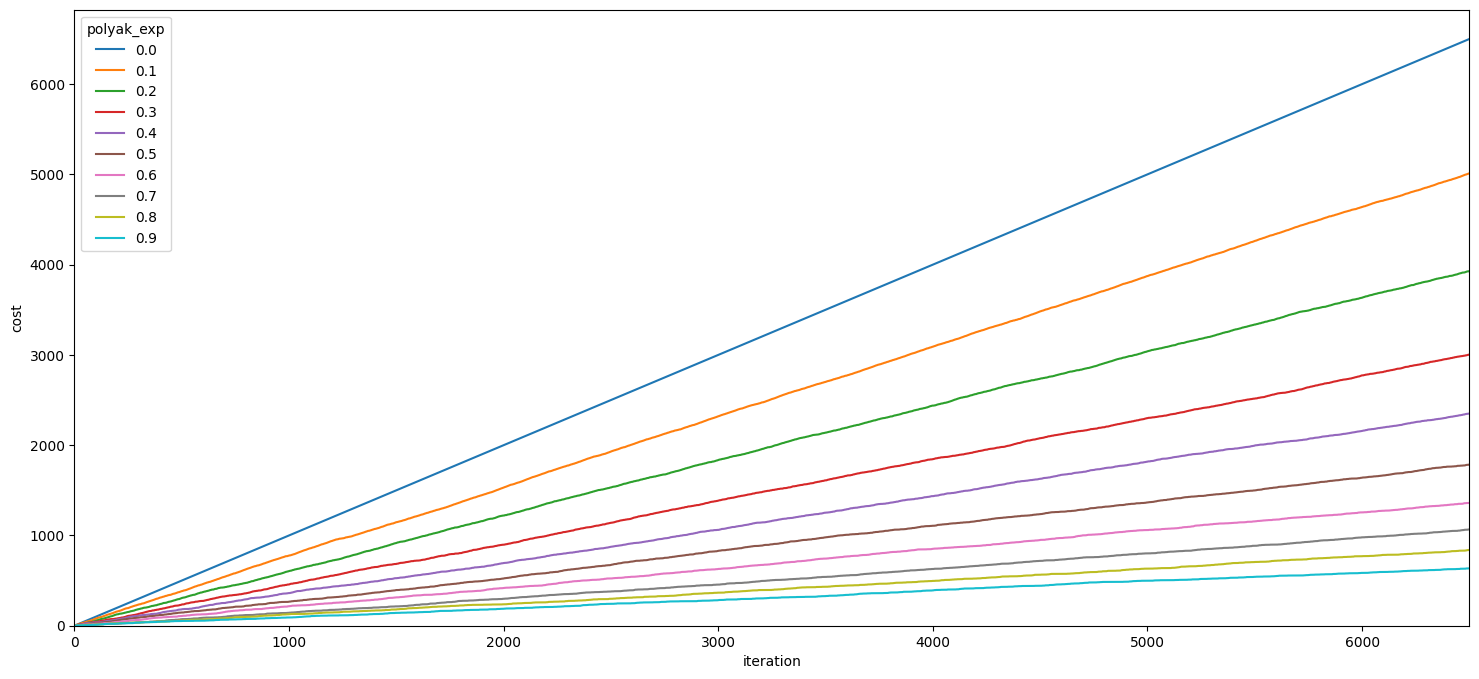

In [54]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="iteration", y="cost", hue="polyak_exp")
ax.set_xlim((0, 6500))
ax.set_ylim(bottom=0)

(0.0, 25.2465902459458)

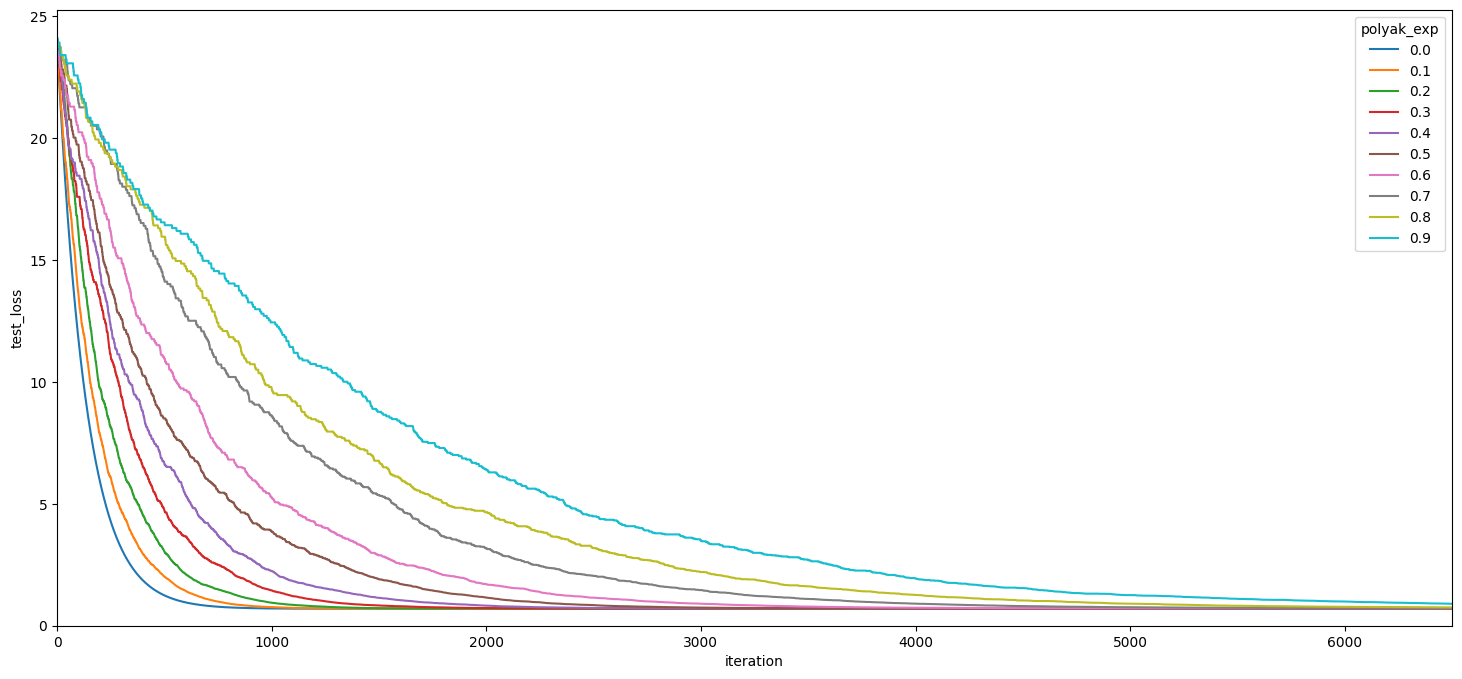

In [55]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="iteration", y="test_loss", hue="polyak_exp")
ax.set_xlim((0, 6500))
ax.set_ylim(bottom=0)

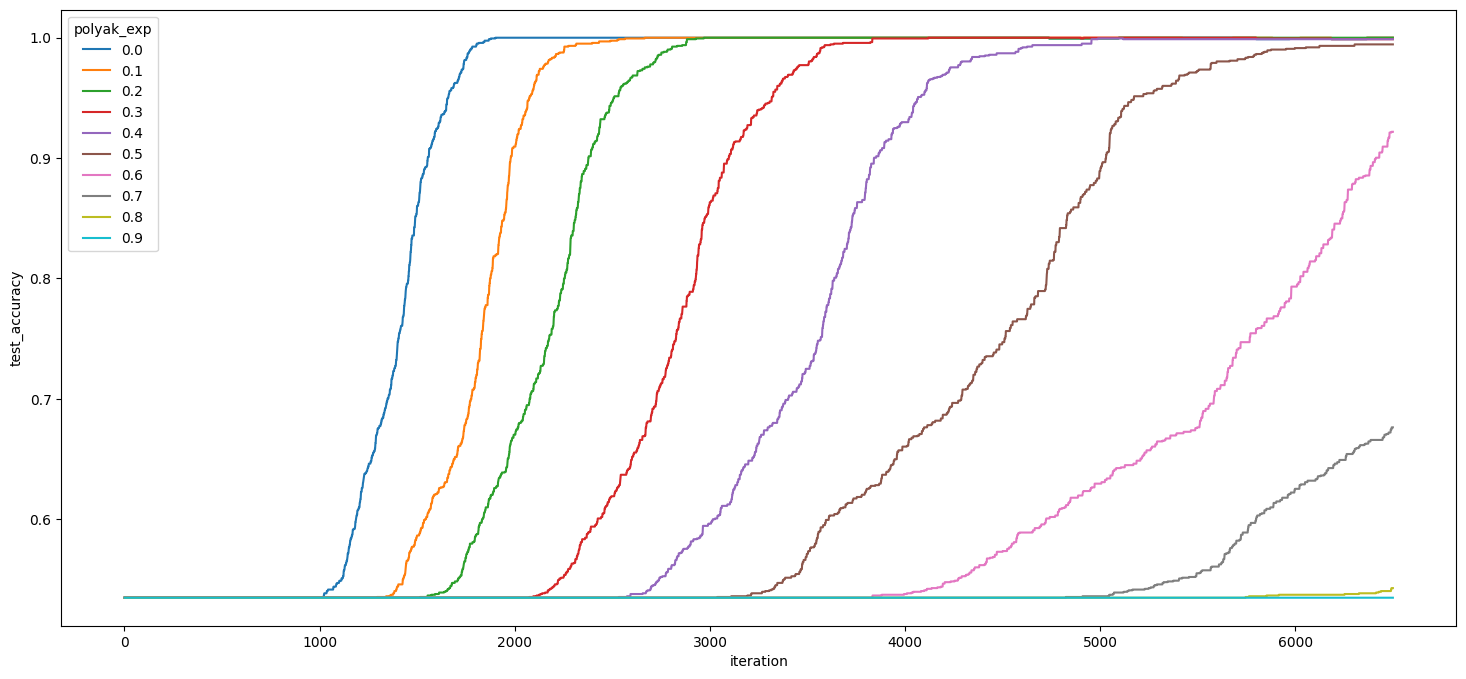

In [56]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="iteration", y="test_accuracy", hue="polyak_exp")

KeyboardInterrupt: 

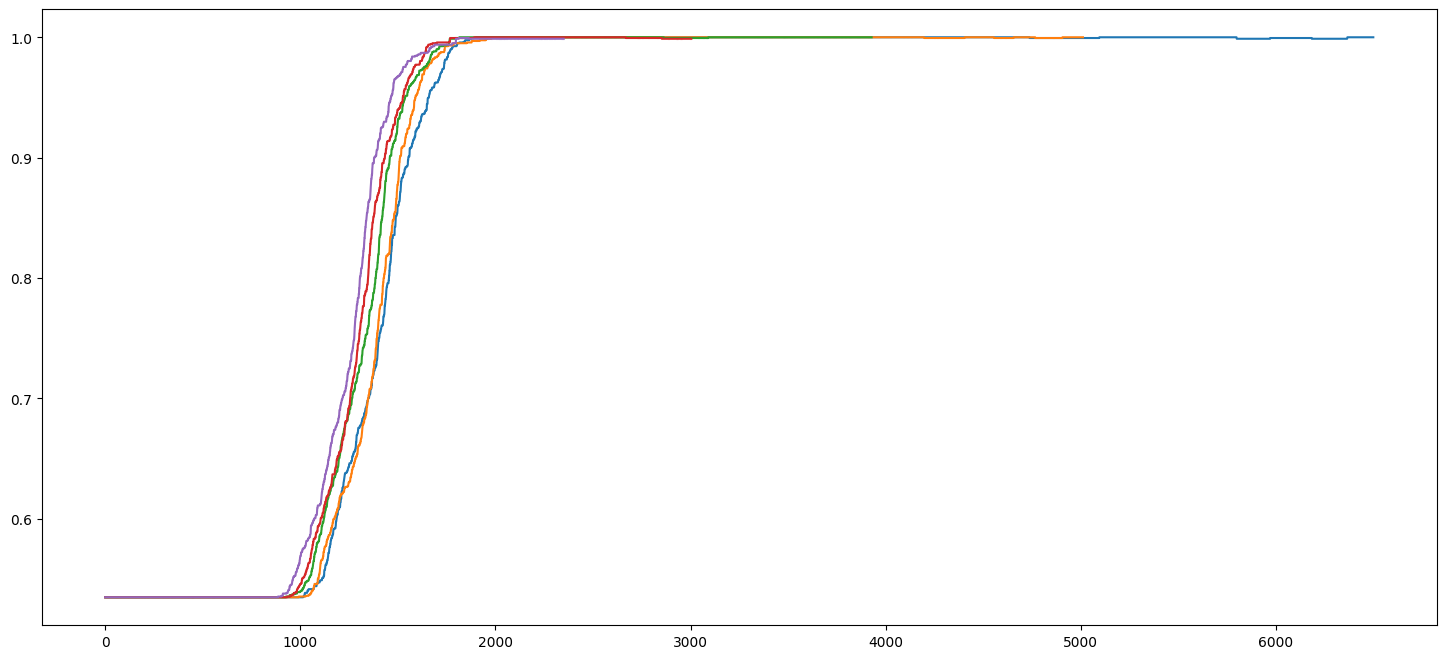

In [43]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="cost", y="test_accuracy", hue="polyak_exp")
ax.set_xlim((0, 4000))

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,8))

ax = sns.lineplot(data=df_test_losses, x="cost", y="test_loss", hue="polyak_exp")
ax.set_xlim((0, 1000))
ax.set_ylim(bottom=0)

## Make comparison plots

In [57]:
df_test_losses["method"] = "polyak_absloss"

import re
df_test_losses_rand = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in rand_results.items()]
)


df_test_losses_rand.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses_rand = df_test_losses_rand.explode(["test_loss", "test_accuracy"])
df_test_losses_rand["iteration"] = df_test_losses_rand.groupby('polyak_exp').cumcount()+1
df_test_losses_rand = df_test_losses_rand.reset_index()
df_test_losses_rand["cost"] = [
    np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses_rand.iteration, df_test_losses_rand.labeled)
]
df_test_losses_rand["method"] = "rand"


import re
df_test_losses_bec_absloss = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in becs_absloss_results.items()]
)


df_test_losses_bec_absloss.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses_bec_absloss = df_test_losses_bec_absloss.explode(["test_loss", "test_accuracy"])
df_test_losses_bec_absloss["iteration"] = df_test_losses_bec_absloss.groupby('polyak_exp').cumcount()+1
df_test_losses_bec_absloss = df_test_losses_bec_absloss.reset_index()
df_test_losses_bec_absloss["cost"] = [
    np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses_bec_absloss.iteration, df_test_losses_bec_absloss.labeled)
]
df_test_losses_bec_absloss["method"] = "absloss"


import re
df_test_losses_polyak_rand = pd.DataFrame(
    [(re.findall("\d.\d", k)[0], v["labeled"], v["losses_test"], v["accuracies_test"]) 
     for k,v in polyak_rand_results.items()]
)
df_test_losses_polyak_rand.columns = ["polyak_exp", "labeled", "test_loss", "test_accuracy"]
df_test_losses_polyak_rand = df_test_losses_polyak_rand.explode(["test_loss", "test_accuracy"])
df_test_losses_polyak_rand["iteration"] = df_test_losses_polyak_rand.groupby('polyak_exp').cumcount()+1
df_test_losses_polyak_rand = df_test_losses_polyak_rand.reset_index()
df_test_losses_polyak_rand["cost"] = [
    np.sum(labels[:iteration]) for iteration, labels in zip(df_test_losses_polyak_rand.iteration, df_test_losses_polyak_rand.labeled)
]
df_test_losses_polyak_rand["method"] = "polyak_rand"

In [58]:
df_test_losses_rand

,index,polyak_exp,labeled,test_loss,test_accuracy,iteration,cost,method
0,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",23.657976,0.534769,1,1,rand
1,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",23.572142,0.534769,2,2,rand
2,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",23.486605,0.534769,3,3,rand
3,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",23.401388,0.534769,4,4,rand
4,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",23.316501,0.534769,5,5,rand
...,...,...,...,...,...,...,...,...
64985,9,0.9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...",2.607421,0.534769,6495,669,rand
64986,9,0.9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...",2.607421,0.534769,6496,669,rand
64987,9,0.9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...",2.607421,0.534769,6497,669,rand
64988,9,0.9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...",2.607421,0.534769,6498,669,rand


In [59]:
df_test_losses

,index,polyak_exp,labeled,test_loss,test_accuracy,iteration,cost,method
0,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",23.832227,0.534769,1,1,polyak_absloss
1,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",23.659544,0.534769,2,2,polyak_absloss
2,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",23.488143,0.534769,3,3,polyak_absloss
3,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",23.318028,0.534769,4,4,polyak_absloss
4,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",23.149191,0.534769,5,5,polyak_absloss
...,...,...,...,...,...,...,...,...
64985,9,0.9,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ...",0.902183,0.534769,6495,634,polyak_absloss
64986,9,0.9,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ...",0.900791,0.534769,6496,635,polyak_absloss
64987,9,0.9,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ...",0.900791,0.534769,6497,635,polyak_absloss
64988,9,0.9,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ...",0.899307,0.534769,6498,636,polyak_absloss


In [60]:
df_test_losses_polyak_rand

,index,polyak_exp,labeled,test_loss,test_accuracy,iteration,cost,method
0,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.972878,0.534769,1,1,polyak_rand
1,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.970054,0.534769,2,2,polyak_rand
2,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.967258,0.534769,3,3,polyak_rand
3,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.964492,0.534769,4,4,polyak_rand
4,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.961753,0.534769,5,5,polyak_rand
...,...,...,...,...,...,...,...,...
64985,9,0.9,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.693359,1.0,6495,615,polyak_rand
64986,9,0.9,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.693357,1.0,6496,615,polyak_rand
64987,9,0.9,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.693355,1.0,6497,615,polyak_rand
64988,9,0.9,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.693354,1.0,6498,615,polyak_rand


In [61]:
df_test_losses_bec_absloss[df_test_losses_bec_absloss.iteration == 6499]

,index,polyak_exp,labeled,test_loss,test_accuracy,iteration,cost,method
6498,0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",0.734525,1.0,6499,6445,absloss
12997,1,0.1,"[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, ...",0.734506,1.0,6499,5039,absloss
19496,2,0.2,"[0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...",0.734544,1.0,6499,3849,absloss
25995,3,0.3,"[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, ...",0.73456,0.992,6499,3034,absloss
32494,4,0.4,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.735404,0.824,6499,2408,absloss
38993,5,0.5,"[1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, ...",0.764517,0.542769,6499,1807,absloss
45492,6,0.6,"[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...",0.956423,0.534769,6499,1354,absloss
51991,7,0.7,"[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",1.365157,0.534769,6499,1068,absloss
58490,8,0.8,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.09294,0.534769,6499,844,absloss
64989,9,0.9,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.478268,0.534769,6499,640,absloss


In [62]:
df_test_losses = pd.concat([df_test_losses_rand, df_test_losses_bec_absloss, df_test_losses, df_test_losses_polyak_rand])

In [63]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

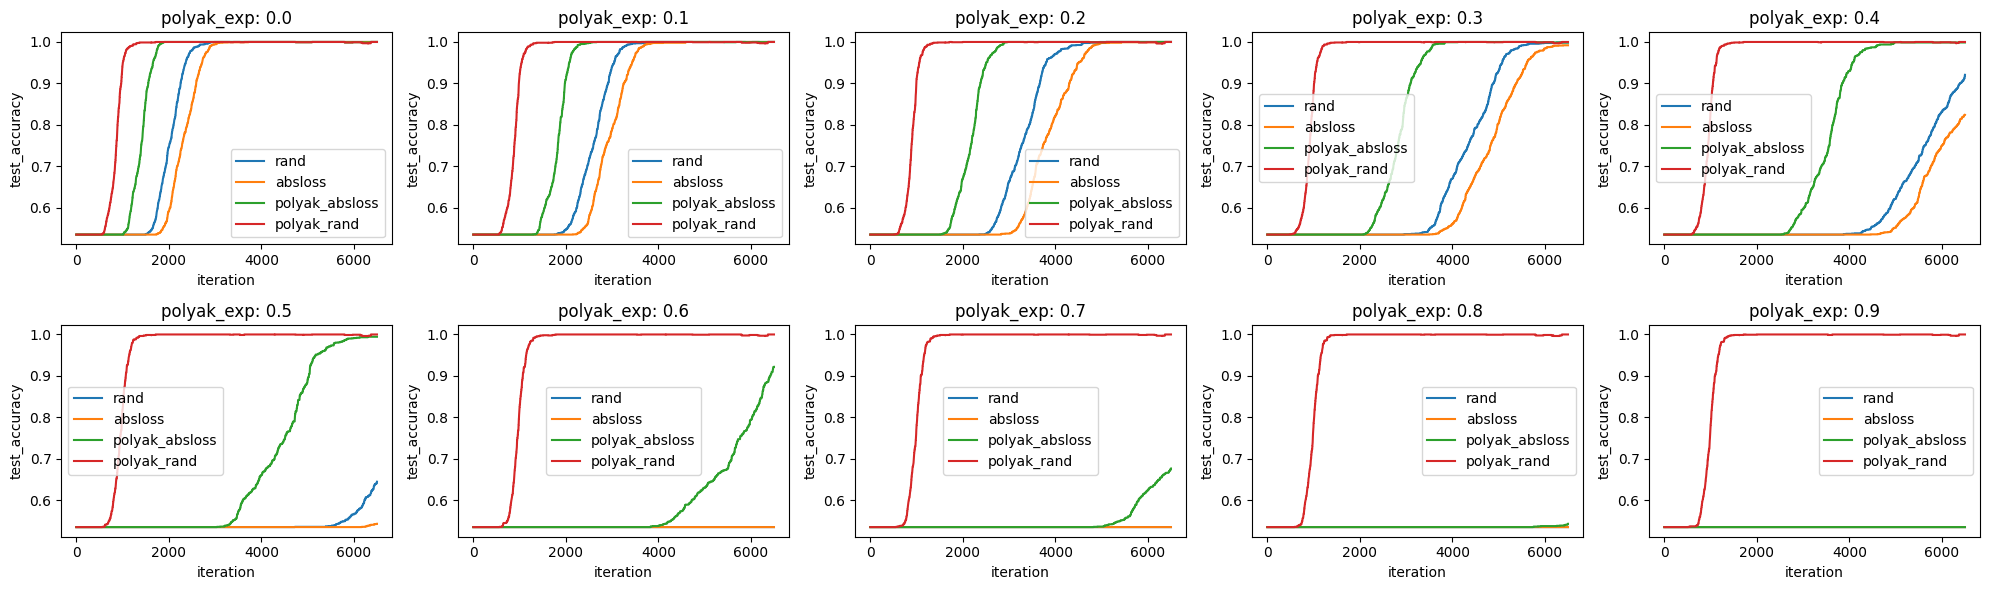

In [64]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

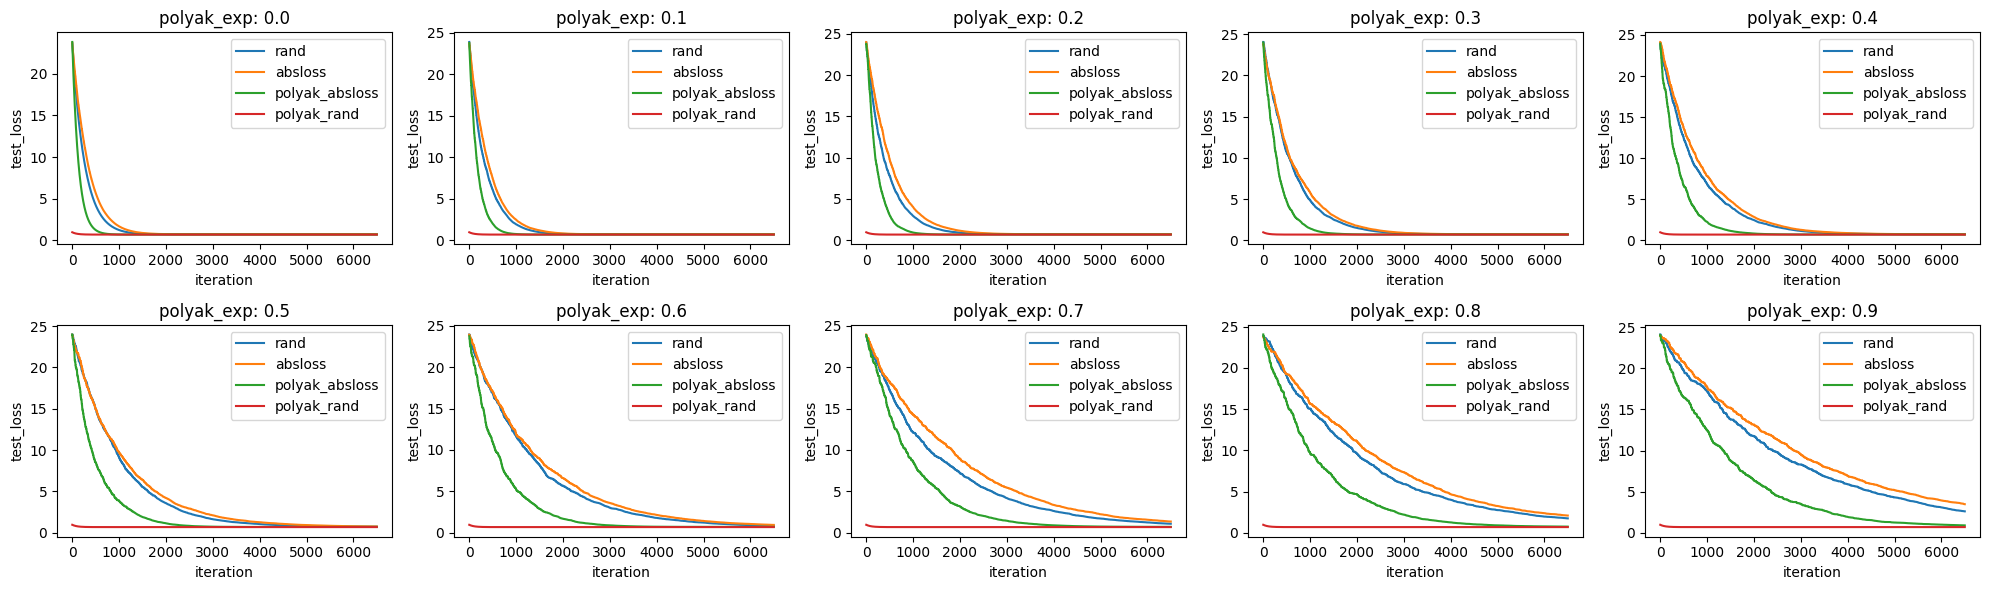

In [65]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

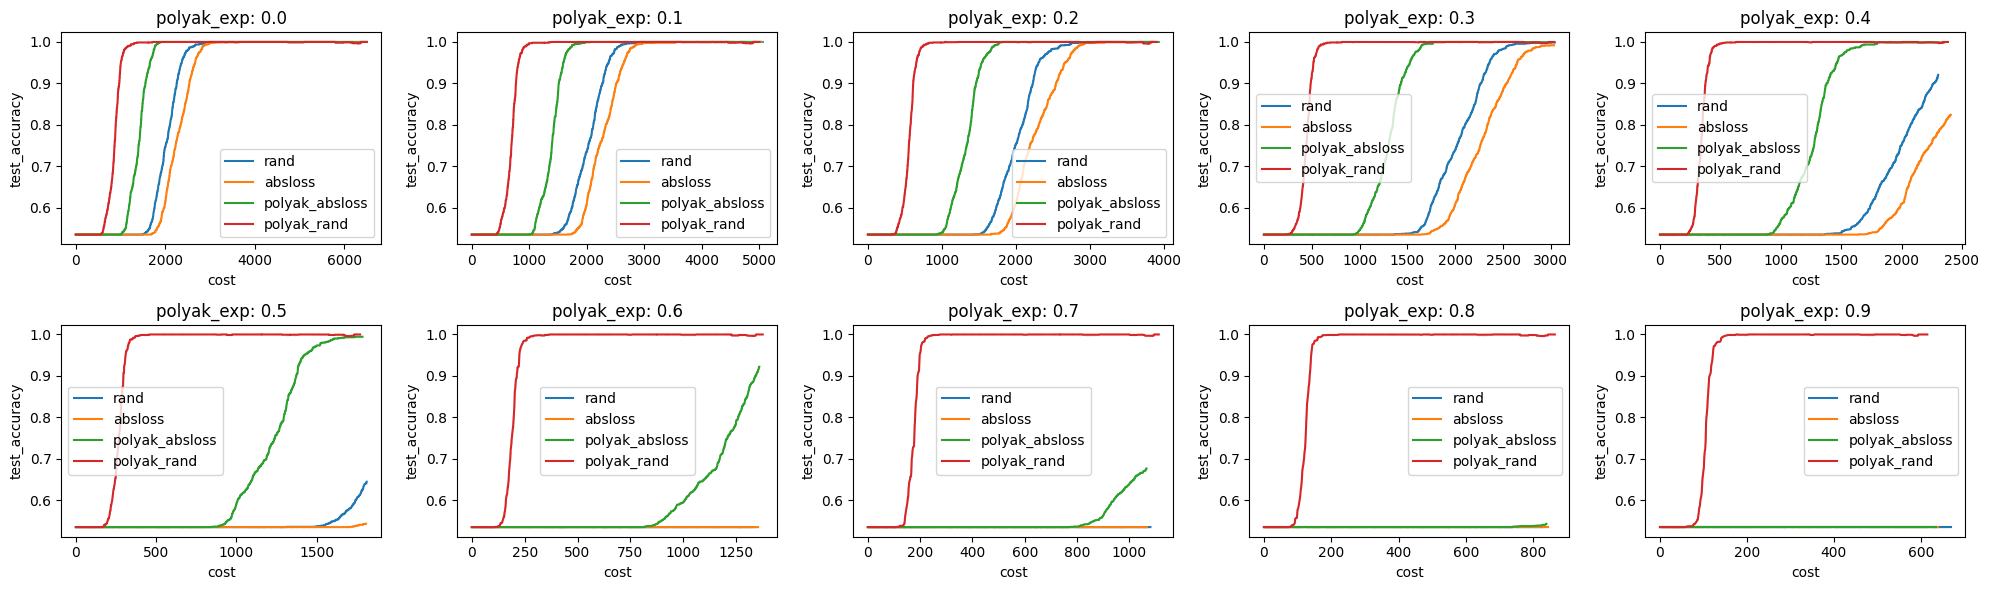

In [67]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="cost", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

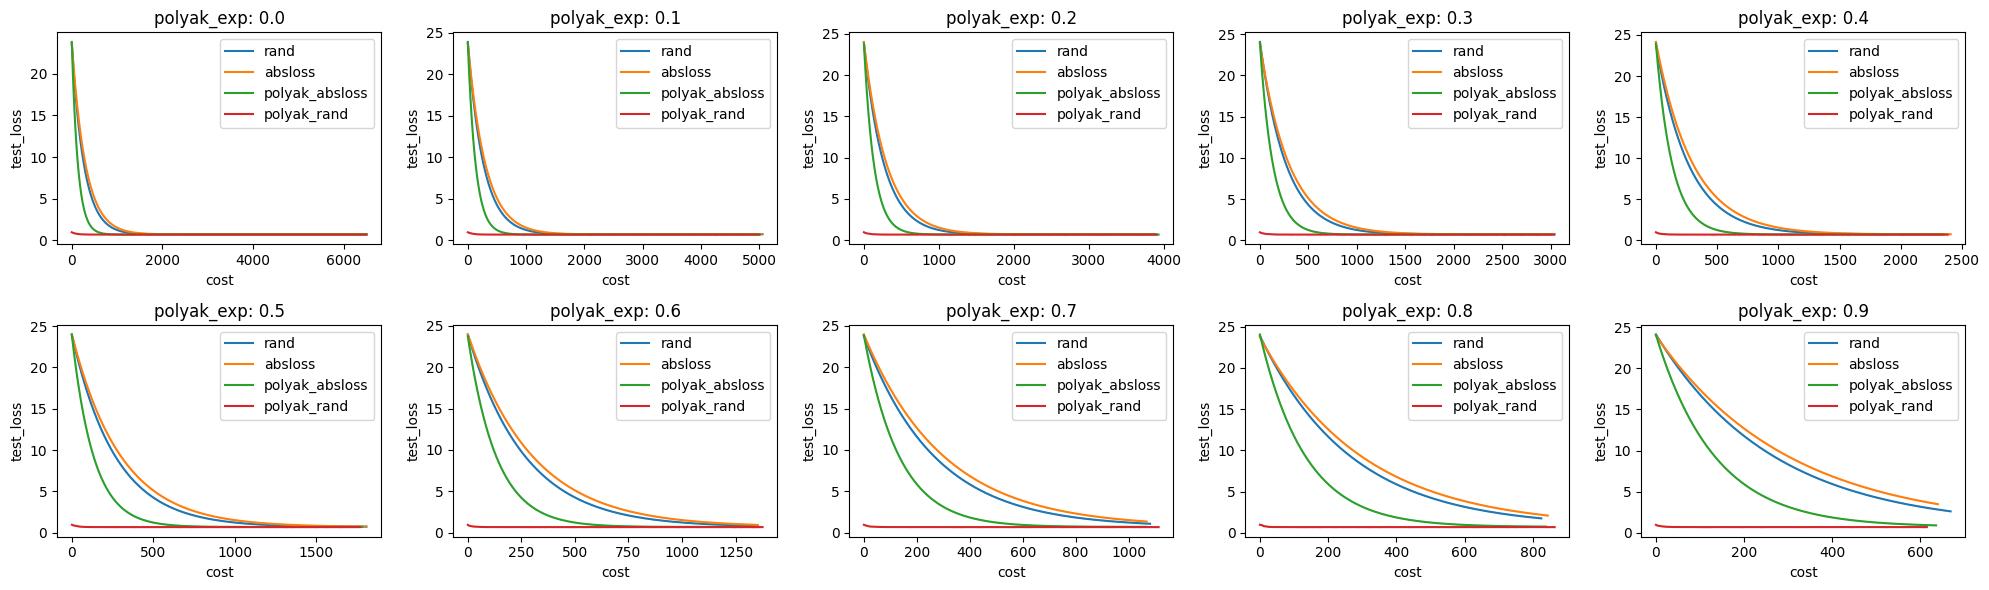

In [68]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="cost", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

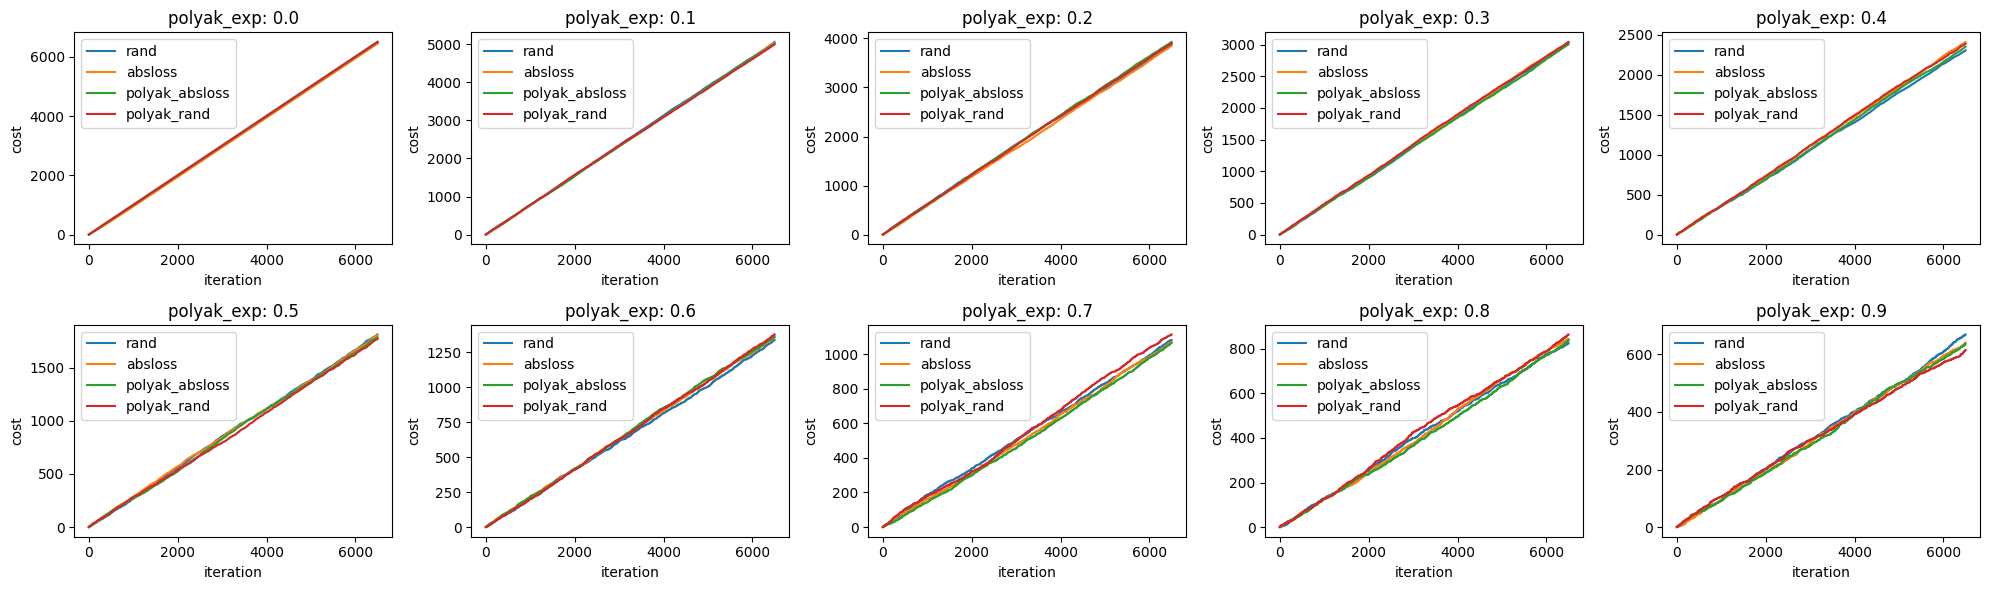

In [66]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[df_test_losses.polyak_exp == polyak_exp], 
        x="iteration", 
        y="cost", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

In [73]:
df_test_losses[(df_test_losses.method == "polyak_rand") & (df_test_losses.test_accuracy > 0.99)].groupby("polyak_exp").agg({"iteration": np.min, "cost": np.min})

,iteration,cost
polyak_exp,,
0.0,1166,1166
0.1,1230,949
0.2,1228,751
0.3,1197,576
0.4,1238,450
0.5,1294,354
0.6,1295,260
0.7,1300,218
0.8,1294,159


In [103]:
def plot_iteration_cost_curve(df, convergence_col="test_accuracy", convergence_threshold=0.99, greater_than=True):
    plt.figure(figsize=(18,8))
    df_iteration_cost_curve = None

    for method in set(df.method):
        if greater_than:
            df_filtered = df_iteration_cost_curve_for_method = df[(df.method == method) & (df[convergence_col] >= convergence_threshold)]
        else:
            df_filtered = df_iteration_cost_curve_for_method = df[(df.method == method) & (df[convergence_col] <= convergence_threshold)]
        df_iteration_cost_curve_for_method = df_filtered.groupby("polyak_exp").agg({"iteration": np.min, "cost": np.min})
        df_iteration_cost_curve_for_method["method"] = method
        if df_iteration_cost_curve is None:
            df_iteration_cost_curve = df_iteration_cost_curve_for_method
        else:
            df_iteration_cost_curve = pd.concat([df_iteration_cost_curve, df_iteration_cost_curve_for_method], axis=0)
            
    ax = sns.lineplot(
        data=df_iteration_cost_curve, x="iteration", y="cost", hue = "method", errorbar=None
    )
    if greater_than:
        ax.set_title(f'Trade/off on iterations and cost to reach {convergence_col}>={convergence_threshold}')
    else:
        ax.set_title(f'Trade/off on iterations and cost to reach {convergence_col}<={convergence_threshold}')

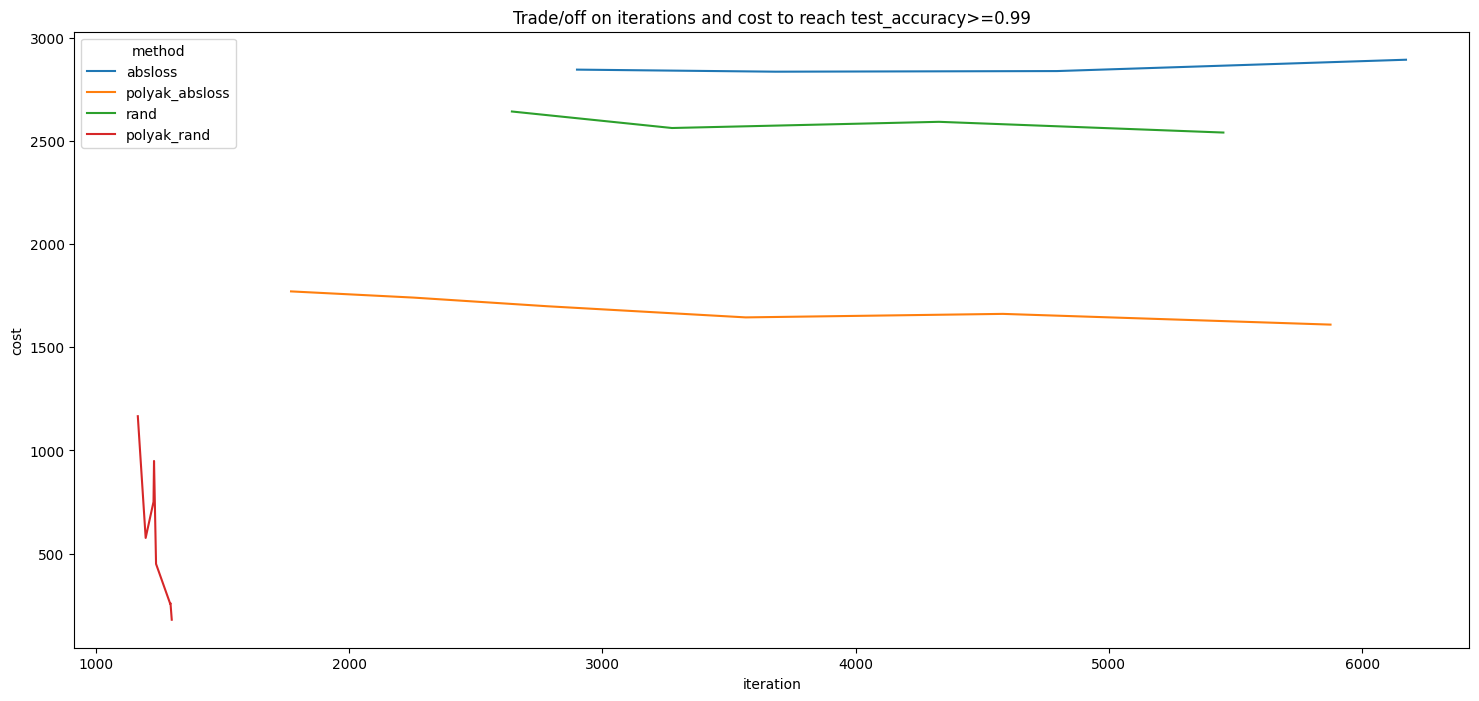

In [104]:
plot_iteration_cost_curve(df_test_losses)

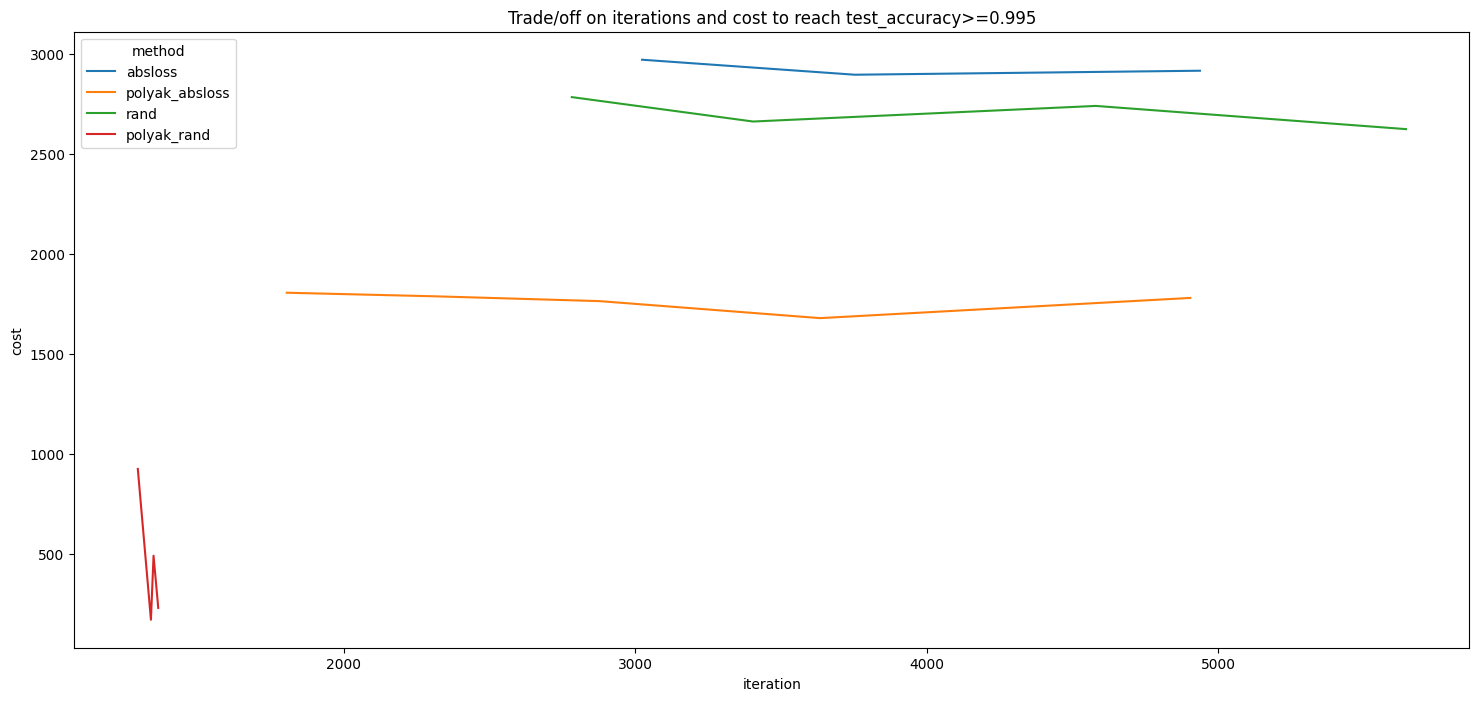

In [108]:
plot_iteration_cost_curve(df_test_losses, convergence_threshold=0.995)

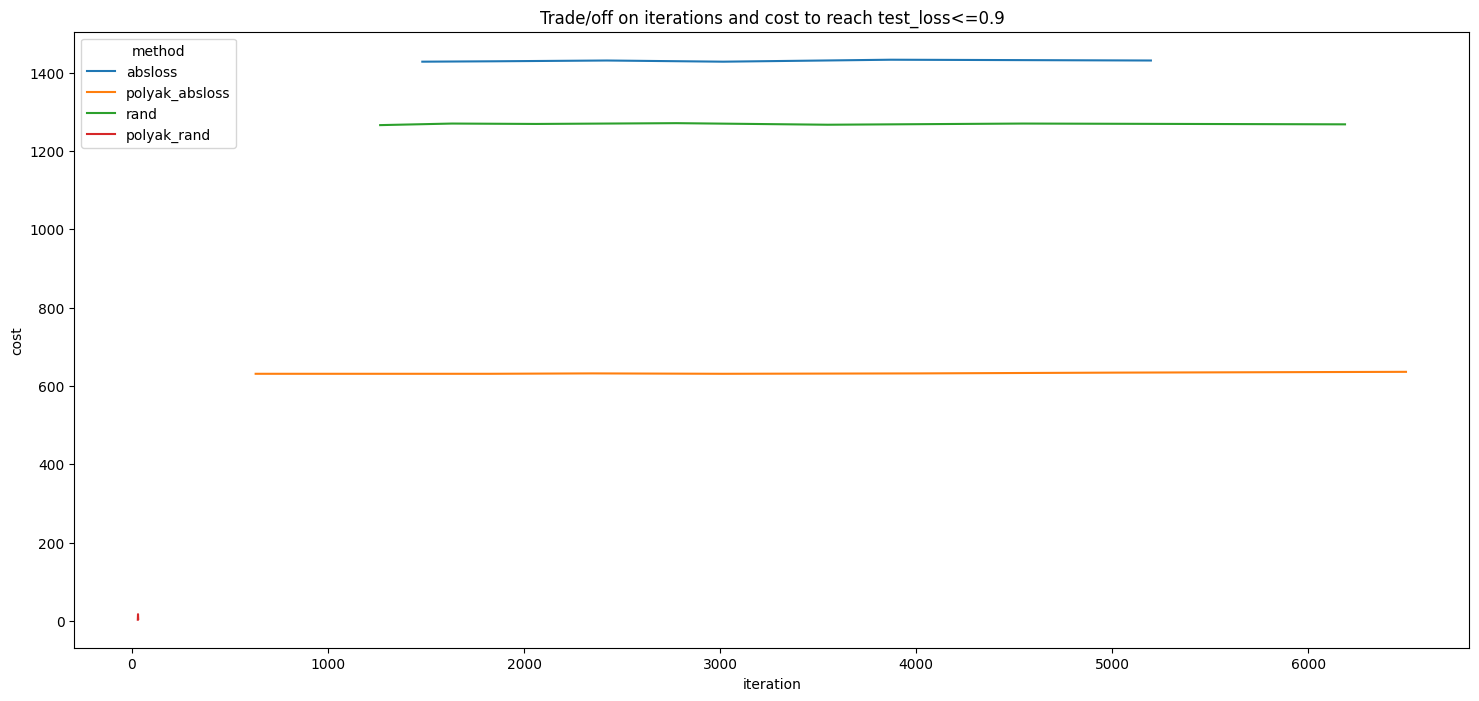

In [116]:
plot_iteration_cost_curve(df_test_losses, convergence_col="test_loss", convergence_threshold=0.9, greater_than=False)

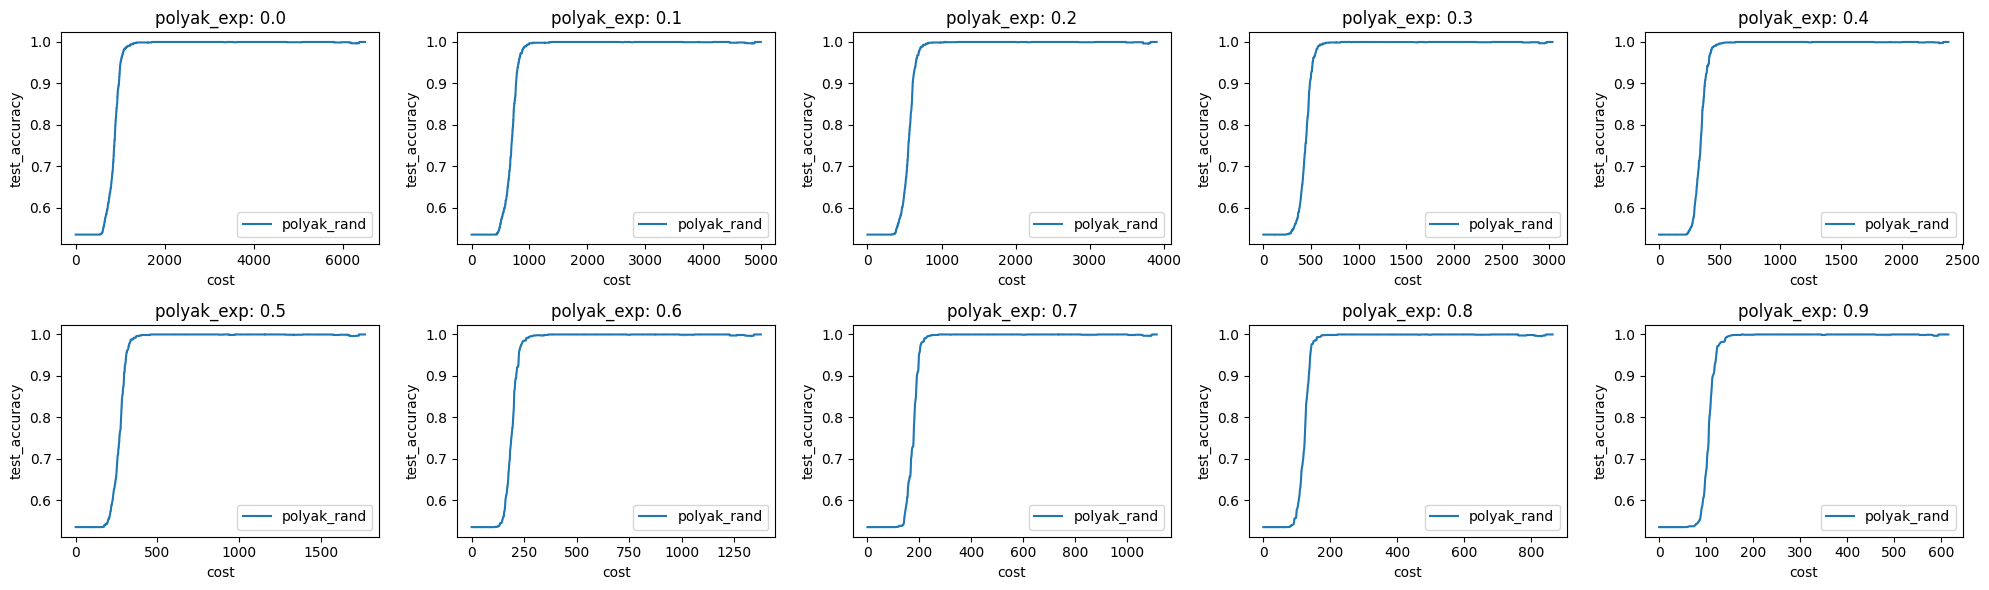

In [117]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[(df_test_losses.polyak_exp == polyak_exp) & (df_test_losses.method == "polyak_rand")], 
        x="cost", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

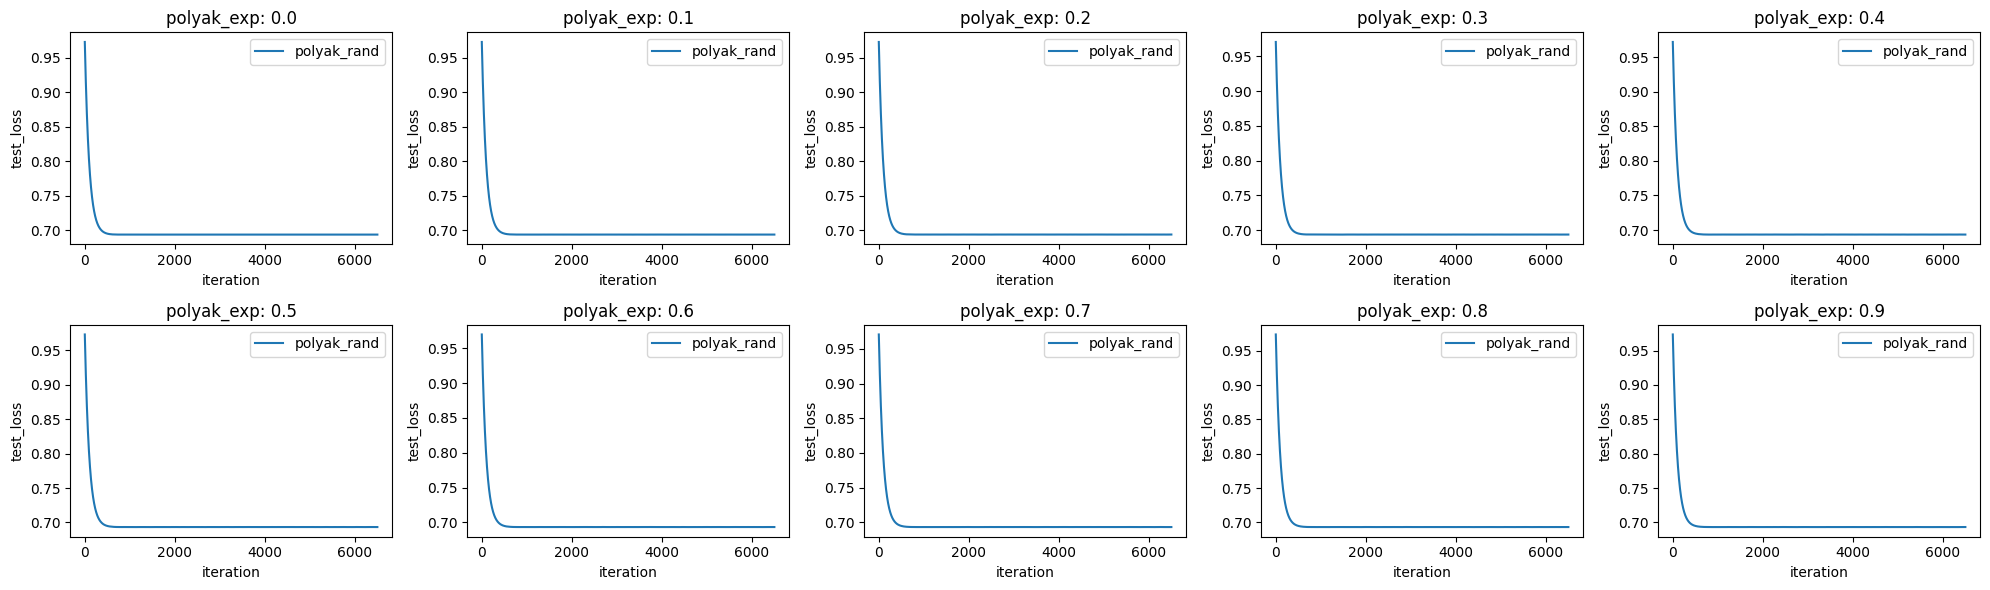

In [118]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[(df_test_losses.polyak_exp == polyak_exp) & (df_test_losses.method == "polyak_rand")], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()

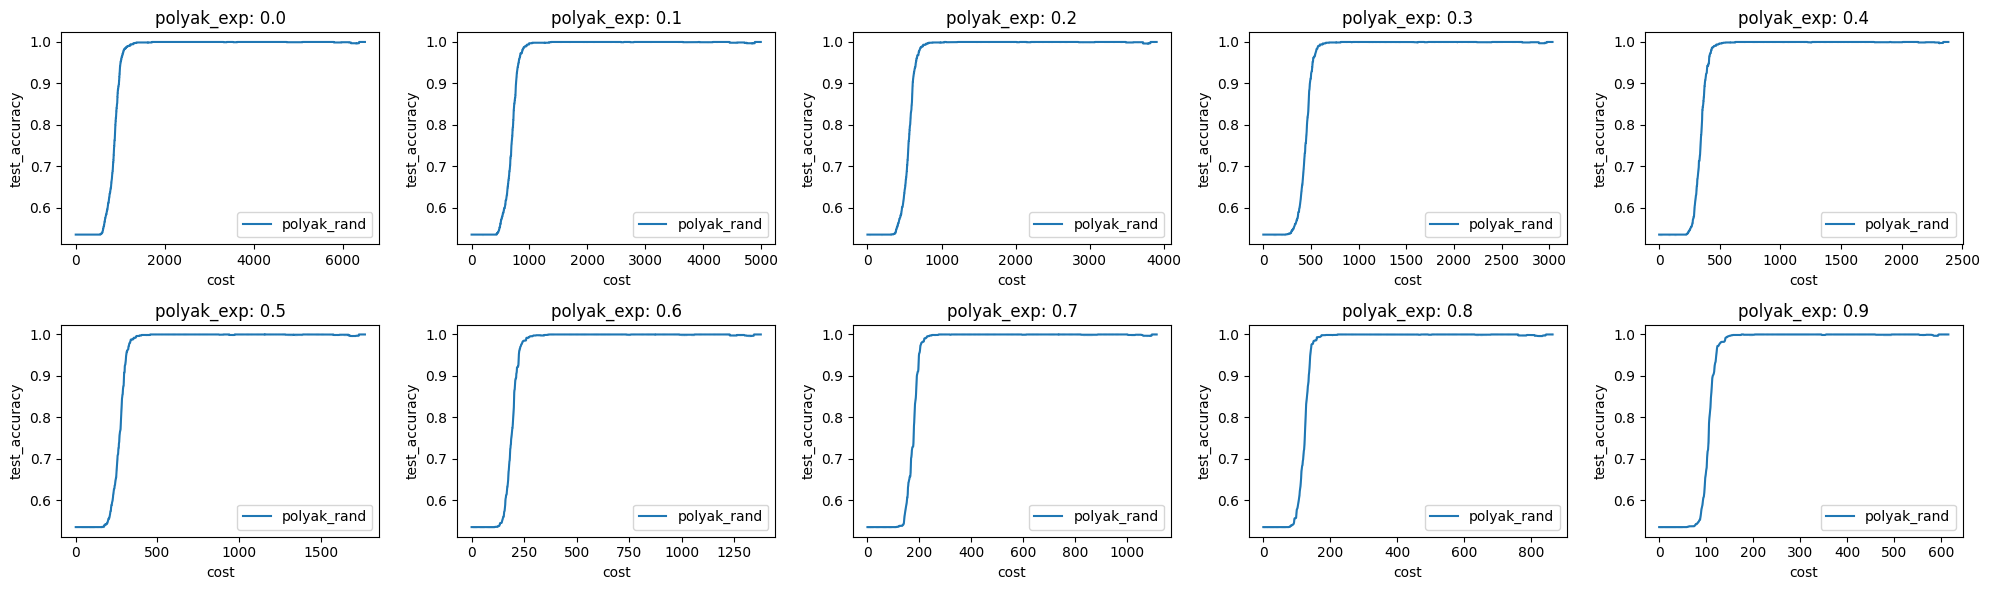

In [119]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, polyak_exp in enumerate(sorted(list(set(df_test_losses.polyak_exp)))):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    # Create the line plot on the current axis
    sns.lineplot(
        data=df_test_losses[(df_test_losses.polyak_exp == polyak_exp) & (df_test_losses.method == "polyak_rand")], 
        x="cost", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"polyak_exp: {polyak_exp}")
    ax.legend()
f.tight_layout()